Columns in customer profile: Index(['CustomerID', 'CustomerName', 'Region', 'SignupDate', 'TotalValue',
       'TransactionID'],
      dtype='object')
Davies-Bouldin Index: 0.7963338823953641


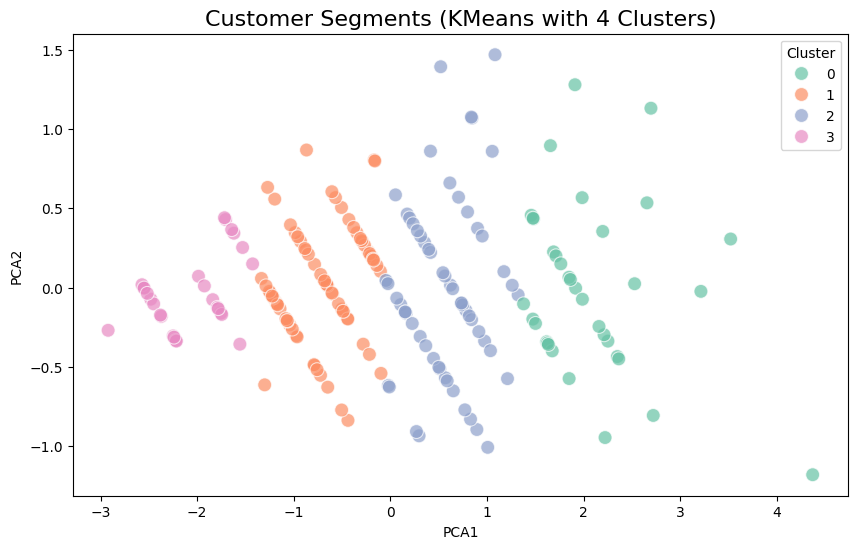

Cluster Summary:
   Cluster  CustomerCount
0        1             76
1        2             62
2        0             35
3        3             27


In [4]:
# Importing necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load the datasets
customers_df = pd.read_csv(r"C:\Users\akhil\OneDrive\Desktop\Customers.csv")
transactions_df = pd.read_csv(r"C:\Users\akhil\OneDrive\Desktop\Transactions.csv")

# Step 2: Merge Transactions with Products to get relevant transaction features
# We need to merge transaction details with customer profile info (CustomerID, Age, Gender, etc.)
merged_df = pd.merge(transactions_df, customers_df, on='CustomerID', how='left')

# Step 3: Create aggregated features for customers
# For simplicity, let's use TotalValue (Total spending) and the number of transactions per customer
customer_spending = merged_df.groupby('CustomerID')['TotalValue'].sum().reset_index()
customer_frequency = merged_df.groupby('CustomerID')['TransactionID'].nunique().reset_index()

# Merge these features back into the customer profile
customer_profile = pd.merge(customers_df, customer_spending, on='CustomerID', how='left')
customer_profile = pd.merge(customer_profile, customer_frequency, on='CustomerID', how='left')

# Handle missing values (e.g., customers who haven't made any transactions)
customer_profile['TotalValue'] = customer_profile['TotalValue'].fillna(0)
customer_profile['TransactionID'] = customer_profile['TransactionID'].fillna(0)

# Check if 'Age' exists in customer_profile
print("Columns in customer profile:", customer_profile.columns)

# If 'Age' is missing in your dataset, you can remove it from the feature selection or handle it differently.
# For now, let's assume 'Age' is not in the dataset, so we will proceed without it.
# If 'Age' exists, you can keep it in the list of selected features.
if 'Age' in customer_profile.columns:
    customer_features = customer_profile[['Age', 'TotalValue', 'TransactionID']]
else:
    customer_features = customer_profile[['TotalValue', 'TransactionID']]

# Step 5: Standardize the features (important for clustering algorithms)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_features)

# Step 6: Apply KMeans Clustering (You can experiment with different numbers of clusters)
n_clusters = 4  # Number of clusters (you can choose any number between 2 and 10)
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
customer_profile['Cluster'] = kmeans.fit_predict(scaled_features)

# Step 7: Evaluate clustering using Davies-Bouldin Index
db_index = davies_bouldin_score(scaled_features, customer_profile['Cluster'])
print(f'Davies-Bouldin Index: {db_index}')

# Step 8: Visualize the clusters using PCA for dimensionality reduction
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_features)

# Add PCA results to the DataFrame for plotting
customer_profile['PCA1'] = reduced_data[:, 0]
customer_profile['PCA2'] = reduced_data[:, 1]

# Plot the clusters in 2D
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', palette='Set2', data=customer_profile, s=100, alpha=0.7)
plt.title(f'Customer Segments (KMeans with {n_clusters} Clusters)', fontsize=16)
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster', loc='upper right')
plt.show()

# Step 9: Cluster Summary
# Show the number of customers in each cluster
cluster_summary = customer_profile['Cluster'].value_counts().reset_index()
cluster_summary.columns = ['Cluster', 'CustomerCount']
print("Cluster Summary:")
print(cluster_summary)

# Step 10: Save the clustering results
customer_profile[['CustomerID', 'Cluster']].to_csv(r"C:\Users\akhil\OneDrive\Desktop\Customer_Clusters.csv", index=False)
